In [ ]:
import time
from nltk import word_tokenize
from collections import Counter
from nltk.corpus import stopwords
import itertools
import pandas as pd
import numpy as np
import scipy as sp
import scipy.sparse
import scipy.sparse.linalg
import sklearn.metrics.pairwise

In [149]:
import os
# this turns off some pesky warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"]="3"

#silences all warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

# Problem 1
## Problem 1a

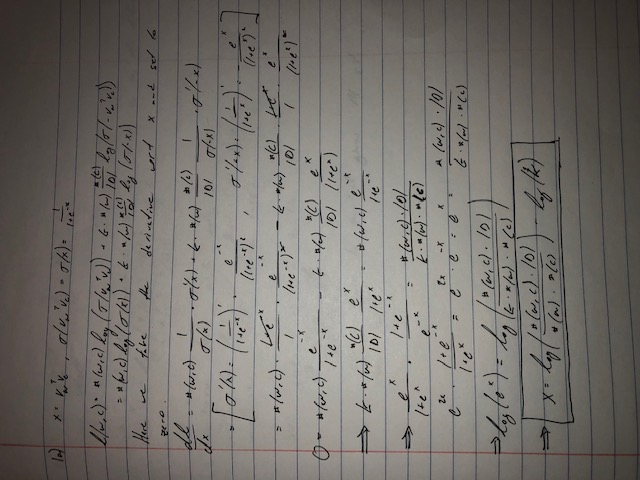

In [1]:
from IPython.display import display, Image
display(Image(filename='problem1a.png'))

## Problem 1b

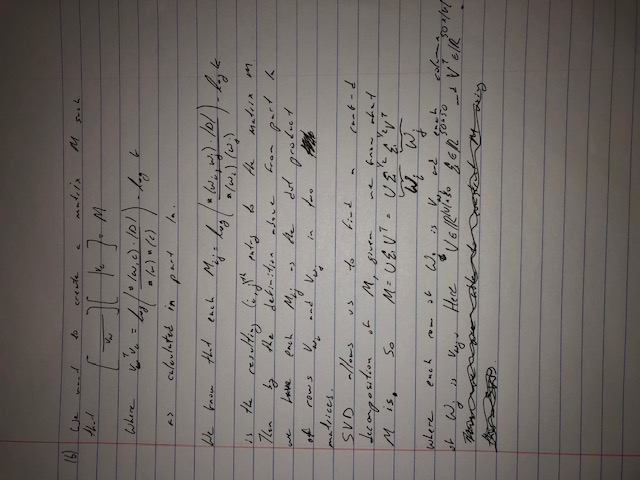

In [2]:
from IPython.display import display, Image
display(Image(filename='problem1b.png'))

# Problem 2 - Embeddings

In [ ]:
fdist = Counter()
for rec in open ('/data/text8', 'r'):
    rec = rec.strip()
    fdist.update(word_tokenize(rec))

In [ ]:
UNIGRAM_LB = 300
sw         = stopwords.words("english")
vocab      = sorted([v for v in fdist.keys() if fdist[v] > UNIGRAM_LB and len(v) >= 3 and v not in sw])
vocab_dict = dict(zip(vocab, range(len(vocab))))
print(len(fdist))
print(len(vocab))

In [ ]:
partial_word = ''
pruned_text  = []
proc = open('pruned-text8.txt', 'w')
with open('/data/text8', 'r') as f:
    for rec in f:
        rec = rec.strip()
        pruned_text_list = [w for w in rec.split() if w in vocab_dict]
        rec = ' '.join(pruned_text_list)
        pruned_text.append(pruned_text_list)
        proc.write(rec + '\n')
pruned_text = list(itertools.chain.from_iterable(pruned_text))

In [ ]:
CONTEXT_SIZE = 5
#co           = np.zeros((len(vocab), len(vocab)))
co_s         = sp.sparse.csr_matrix((len(vocab), len(vocab))) # empty matrix

# for sparse matrix construction
d    = []
rows = []
cols = []

for h_idx in range(len(pruned_text)):
    
    l_idx = max(0, h_idx - CONTEXT_SIZE)
    r_idx = min(len(pruned_text)-1, h_idx + CONTEXT_SIZE)

    for l in range(l_idx, h_idx):
        #co[vocab_dict[pruned_text[h_idx]], vocab_dict[pruned_text[l]]] += 1
        rows.append(vocab_dict[pruned_text[h_idx]])
        cols.append(vocab_dict[pruned_text[l]])
        d.append(1)
        
    for r in range(h_idx, r_idx+1):
        #co[vocab_dict[pruned_text[h_idx]], vocab_dict[pruned_text[r]]] += 1
        rows.append(vocab_dict[pruned_text[h_idx]])
        cols.append(vocab_dict[pruned_text[r]])
        d.append(1)
    
    if h_idx % 1000000 == 0 and h_idx != 0:
        print(h_idx)
        co_s = co_s + sp.sparse.csr_matrix((d, (rows, cols)), shape=(len(vocab), len(vocab)))
        d    = []
        rows = []
        cols = []

if len(d) > 0:
    co_s = co_s + sp.sparse.csr_matrix((d, (rows, cols)), shape=(len(vocab), len(vocab)))

## Problem 2a - Define matrix M

In [ ]:
rowsum = co_s.sum(axis=1)
colsum = co_s.sum(axis=0)
D = np.sum(co_s)/2

In [ ]:
M = np.log((co_s + np.ones((len(vocab),len(vocab))))*D/np.outer(rowsum,colsum))

## Problem 2b - SVD decomposition of M

In [ ]:
U, s, V = scipy.sparse.linalg.svds(M, k=50)

In [ ]:
#We can do this test from the given code to confirm that we have gotten M correct.
D = sklearn.metrics.pairwise.pairwise_distances(V.T)
test_words = ['republican', 'physics', 'baseball', 'chicago', 'fish', 'algebra', 'rock', 'food', 'einstein']
for t in test_words:
    print("{}: {}".format(t, [vocab[np.argsort(D[vocab_dict[t],:])[i]] for i in range(1,5)]))

## Problem 2c - W word embeddings and distances

In [ ]:
sig = np.diag(s)
W = np.matmul(U,np.sqrt(sig))

In [ ]:
import gensim
from gensim.models import KeyedVectors

In [ ]:
#This code is from Professor Lafferty's Piazza post to export the word embedding distances.
file = open('myembeddings.txt', 'w')
d = 50
file.write("%d %d\n" % (len(vocab), d))
for word in range(len(vocab)):
    file.write("%s" % vocab[word])
    vec = W[word]
    for j in range(d):
        file.write(" %f" % vec[j])
    file.write("\n")
file.close()

# Problem 2 - Experiments

## 2a-b for the PMI embeddings calculated above.

In [152]:
#PMI embeddings written in part c above
embed = KeyedVectors.load_word2vec_format("myembeddings.txt", binary=False)

2018-11-27 20:11:38,679 : INFO : loading projection weights from myembeddings.txt
2018-11-27 20:11:38,903 : INFO : loaded (5044, 50) matrix from myembeddings.txt


In [153]:
embeddf = pd.DataFrame(data = {'Yale':embed.most_similar('yale',topn=5),
'Physics':embed.most_similar('physics',topn=5),
'Republican':embed.most_similar('republican',topn=5),
'Einstein':embed.most_similar('einstein',topn=5),
'Algebra':embed.most_similar('algebra',topn=5),
'Fish':embed.most_similar('fish',topn=5),
'Apple':embed.most_similar('apple',topn=5),
'Music':embed.most_similar('music',topn=5),
'Girl':embed.most_similar('girl',topn=5),
'Baseball':embed.most_similar('baseball',topn=5),
'Atom':embed.most_similar('atom',topn=5)})

embeddf.T

2018-11-27 20:11:39,311 : INFO : precomputing L2-norms of word weight vectors


,0,1,2,3,4
Yale,"(princeton, 0.9425637722015381)","(cornell, 0.9210110306739807)","(faculty, 0.8648125529289246)","(stanford, 0.864163339138031)","(toronto, 0.8456763029098511)"
Physics,"(mechanics, 0.869025468826294)","(quantum, 0.8668453097343445)","(einstein, 0.8146789073944092)","(relativity, 0.7639111876487732)","(mathematical, 0.7594526410102844)"
Republican,"(democrats, 0.828607976436615)","(presidential, 0.8204923868179321)","(candidate, 0.7982932329177856)","(senator, 0.7937159538269043)","(presidency, 0.7843808531761169)"
Einstein,"(relativity, 0.8877260088920593)","(newton, 0.869674801826477)","(mechanics, 0.8252074122428894)","(physics, 0.8146789073944092)","(quantum, 0.7966133952140808)"
Algebra,"(theorem, 0.9179235100746155)","(finite, 0.9136441946029663)","(algebraic, 0.903759777545929)","(spaces, 0.8752715587615967)","(calculus, 0.8671188354492188)"
Fish,"(fruit, 0.829826295375824)","(food, 0.8073203563690186)","(plants, 0.806782066822052)","(plant, 0.8018413186073303)","(wild, 0.7936666011810303)"
Apple,"(ibm, 0.9085429906845093)","(microsoft, 0.8996783494949341)","(windows, 0.8539339303970337)","(intel, 0.8481268882751465)","(macintosh, 0.8469673991203308)"
Music,"(musical, 0.9141595363616943)","(dance, 0.8525969982147217)","(jazz, 0.827820897102356)","(songs, 0.8107204437255859)","(band, 0.7946650981903076)"
Girl,"(boys, 0.8387066125869751)","(baby, 0.8185356855392456)","(boy, 0.7971219420433044)","(girls, 0.7790989875793457)","(woman, 0.7567849159240723)"
Baseball,"(football, 0.8958489894866943)","(nfl, 0.8830759525299072)","(team, 0.8575968742370605)","(league, 0.8480815887451172)","(teams, 0.8358676433563232)"


In [154]:
#Analogies
analogydf = pd.DataFrame(data = 
       {"England:":embed.most_similar(positive=['england', 'paris'], negative=['france'],topn=1),
        "Germany:":embed.most_similar(positive=['germany', 'paris'], negative=['france'],topn=1),
        "King:":embed.most_similar(positive=['king', 'woman'], negative=['queen'],topn=1),
        "Art:":embed.most_similar(positive=['art', 'actor'], negative=['movie'],topn=1),
        "Dry:":embed.most_similar(positive=['dry', 'big'], negative=['small'],topn=1),
        "Wolf:":embed.most_similar(positive=['wolf', 'school'], negative=['fish'],topn=1),
        "Bird:":embed.most_similar(positive=['bird', 'arm'], negative=['human'],topn=1),
        "Boat:":embed.most_similar(positive=['boat', 'road'], negative=['car'],topn=1)})

#Some of these analogies are pretty poor, while others are correct.
analogydf.T

,0
England:,"(london, 0.7432724237442017)"
Germany:,"(berlin, 0.9100192189216614)"
King:,"(man, 0.7669044733047485)"
Art:,"(composer, 0.7070595026016235)"
Dry:,"(snow, 0.6954966187477112)"
Wolf:,"(graduate, 0.7145970463752747)"
Bird:,"(hat, 0.8253781199455261)"
Boat:,"(shore, 0.8118772506713867)"


### Comments:

For all of the top 5 most similar words, we see generally very expected results. For "yale", "harvard" is surprisingly not listed in the top 5, but "toronto" is. For "fish", we see the most similar word is "fruit". I would certainly not expect this, I would have expected "water" or "swim" to be in the top 5 but are not. For "apple", all the closest words are related to the company Apple and not the fruit.

When looking at the analogies, the first 3 are all correct completions of the analogy. However, for some of the analgoies I chose, we get very odd results. For example, fish : school :: wolf : ? gave "graduate" instead of "pack" (school of fish and pack of wolves). Also, for the analogy human : arm :: bird : ? give "hat instead of wing. Neither of these analogy completions seem correct at all, however I am using the same notation as I did for the all the correct analogies.

## Parts 2a-b for the local word2vec embeddings.

In [ ]:
#local word2vec embeddings from text8
from gensim.models import word2vec
import logging
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s", \
level=logging.INFO)
sentences = word2vec.Text8Corpus("/data/text8")
model = word2vec.Word2Vec(sentences, size=100, window=10, min_count=10)

In [150]:
modeldf = pd.DataFrame(data = {'Yale':model.most_similar('yale',topn=5),
'Physics':model.most_similar('physics',topn=5),
'Republican':model.most_similar('republican',topn=5),
'Einstein':model.most_similar('einstein',topn=5),
'Algebra':model.most_similar('algebra',topn=5),
'Fish':model.most_similar('fish',topn=5),
'Apple':model.most_similar('apple',topn=5),
'Music':model.most_similar('music',topn=5),
'Girl':model.most_similar('girl',topn=5),
'Baseball':model.most_similar('baseball',topn=5),
'Atom':model.most_similar('atom',topn=5)})

modeldf.T

,0,1,2,3,4
Yale,"(harvard, 0.8333485722541809)","(rutgers, 0.8185535669326782)","(princeton, 0.798017144203186)","(cornell, 0.7770333290100098)","(mcgill, 0.7425099611282349)"
Physics,"(mechanics, 0.8072901964187622)","(chemistry, 0.7467066645622253)","(electromagnetism, 0.7457118630409241)","(quantum, 0.7326217293739319)","(optics, 0.7323855757713318)"
Republican,"(republicans, 0.8518327474594116)","(democrat, 0.8299705982208252)","(democrats, 0.7877575755119324)","(mps, 0.7441299557685852)","(democratic, 0.7255265116691589)"
Einstein,"(fermi, 0.8155539035797119)","(heisenberg, 0.7874090671539307)","(maxwell, 0.7786605954170227)","(planck, 0.7741504907608032)","(schr, 0.771353542804718)"
Algebra,"(algebraic, 0.8709201216697693)","(topology, 0.8354673385620117)","(associative, 0.8263828754425049)","(banach, 0.8227407932281494)","(boolean, 0.8075627088546753)"
Fish,"(fruit, 0.8306139707565308)","(goldfish, 0.8121287226676941)","(sheep, 0.8117778301239014)","(shrimp, 0.8084115982055664)","(crab, 0.8030469417572021)"
Apple,"(macintosh, 0.8119014501571655)","(amiga, 0.749693751335144)","(intel, 0.738930344581604)","(atari, 0.7256022095680237)","(pc, 0.7229448556900024)"
Music,"(musical, 0.7845925092697144)","(jazz, 0.7530624866485596)","(dance, 0.7048557996749878)","(pop, 0.6823176145553589)","(folk, 0.679400622844696)"
Girl,"(maid, 0.7947046756744385)","(baby, 0.791813850402832)","(thief, 0.7798421382904053)","(kid, 0.7793695330619812)","(girls, 0.7668563723564148)"
Baseball,"(nba, 0.7584875226020813)","(basketball, 0.7437807321548462)","(mlb, 0.7142607569694519)","(nhl, 0.7128868103027344)","(football, 0.6926030516624451)"


In [151]:
#Analogies
analogydf = pd.DataFrame(data = 
       {"England:":model.most_similar(positive=['england', 'paris'], negative=['france'],topn=1),
        "Germany:":model.most_similar(positive=['germany', 'paris'], negative=['france'],topn=1),
        "King:":model.most_similar(positive=['king', 'woman'], negative=['queen'],topn=1),
        "Art:":model.most_similar(positive=['art', 'actor'], negative=['movie'],topn=1),
        "Dry:":model.most_similar(positive=['dry', 'big'], negative=['small'],topn=1),
        "Wolf:":model.most_similar(positive=['wolf', 'school'], negative=['fish'],topn=1),
        "Bird:":model.most_similar(positive=['bird', 'arm'], negative=['human'],topn=1),
        "Boat:":model.most_similar(positive=['boat', 'road'], negative=['car'],topn=1)})

#Some of these analogies are pretty poor, while others are correct.
analogydf.T

,0
England:,"(edinburgh, 0.682218611240387)"
Germany:,"(berlin, 0.8431386351585388)"
King:,"(man, 0.7167108058929443)"
Art:,"(painter, 0.6134625673294067)"
Dry:,"(cool, 0.70130455493927)"
Wolf:,"(professor, 0.5517845153808594)"
Bird:,"(jacket, 0.6577721834182739)"
Boat:,"(shore, 0.7691932916641235)"


### Comments:

For the most similar local word2vec embeddings, we again see reasonable results overall. "yale" and "harvard" are most similar, which is more expected than what we saw in the PMI embeddings. Again "fish" has many weird results. "Fruit" remains the most similar word and "sheep" is in the top 3; however we do see "goldfish" and "shrimp" which are reasonable. We continue to get technology company related words as most similar to "apple" instead of fruit related words. The rest of the results are very expected.

When looking at the analogies, we again have a mixture of expected and unexpected results. Instead of "london", it completes the first analogy with "edinburgh", the capital of Scottland not England. The following three analogies are completed correctly. Again, we see very odd answers for the fish : school :: wolf : ? analogy. It lists "professor" as the best answer. Similarly, it gives "jacket" instead of "wings".

## Parts 2a-c for the pre-trained GloVe embeddings.

In [ ]:
#Pre-trained GloVe
import gensim.downloader as gdl
glove = gdl.load("glove-wiki-gigaword-100")

In [116]:
glovedf = pd.DataFrame(data = {'Yale':glove.most_similar('yale',topn=5),
'Physics':glove.most_similar('physics',topn=5),
'Republican':glove.most_similar('republican',topn=5),
'Einstein':glove.most_similar('einstein',topn=5),
'Algebra':glove.most_similar('algebra',topn=5),
'Fish':glove.most_similar('fish',topn=5),
'Apple':glove.most_similar('apple',topn=5),
'Music':glove.most_similar('music',topn=5),
'Girl':glove.most_similar('girl',topn=5),
'Baseball':glove.most_similar('baseball',topn=5),
'Atom':glove.most_similar('atom',topn=5)})

glovedf.T

,0,1,2,3,4
Yale,"(harvard, 0.9161344766616821)","(princeton, 0.867539644241333)","(university, 0.8113802671432495)","(cornell, 0.8014455437660217)","(stanford, 0.787754476070404)"
Physics,"(chemistry, 0.8498000502586365)","(mathematics, 0.834094762802124)","(science, 0.7914698719978333)","(biology, 0.7894973158836365)","(theoretical, 0.7342938780784607)"
Republican,"(gop, 0.9306843280792236)","(democrat, 0.8788904547691345)","(democratic, 0.8735148906707764)","(republicans, 0.8709758520126343)","(democrats, 0.8635865449905396)"
Einstein,"(relativity, 0.6908349394798279)","(freud, 0.6417257785797119)","(physics, 0.6145339012145996)","(bohr, 0.6144247055053711)","(theory, 0.6042598485946655)"
Algebra,"(algebras, 0.7539783716201782)","(geometry, 0.6790961027145386)","(algebraic, 0.6474162340164185)","(boolean, 0.6418250799179077)","(commutative, 0.6322143077850342)"
Fish,"(shrimp, 0.7793381214141846)","(salmon, 0.7608143091201782)","(tuna, 0.7485246658325195)","(meat, 0.7119255065917969)","(seafood, 0.6940563321113586)"
Apple,"(microsoft, 0.7449405789375305)","(ibm, 0.6821643710136414)","(intel, 0.6778088212013245)","(software, 0.6775422096252441)","(dell, 0.6741442680358887)"
Music,"(musical, 0.8128044605255127)","(songs, 0.7978180050849915)","(dance, 0.7896507978439331)","(pop, 0.7862942218780518)","(recording, 0.7650765180587769)"
Girl,"(boy, 0.9175729155540466)","(woman, 0.847267210483551)","(girls, 0.7953022718429565)","(mother, 0.78807133436203)","(child, 0.7634811997413635)"
Baseball,"(basketball, 0.7645361423492432)","(leagues, 0.7626136541366577)","(football, 0.7605736255645752)","(league, 0.7323170900344849)","(hockey, 0.7312085628509521)"


In [117]:
#Analogies
analogydf = pd.DataFrame(data = 
       {"England:":glove.most_similar(positive=['england', 'paris'], negative=['france'],topn=1),
        "Germany:":glove.most_similar(positive=['germany', 'paris'], negative=['france'],topn=1),
        "King:":glove.most_similar(positive=['king', 'woman'], negative=['queen'],topn=1),
        "Art:":glove.most_similar(positive=['art', 'actor'], negative=['movie'],topn=1),
        "Dry:":glove.most_similar(positive=['dry', 'big'], negative=['small'],topn=1),
        "Wolf:":glove.most_similar(positive=['wolf', 'school'], negative=['fish'],topn=1),
        "Bird:":glove.most_similar(positive=['bird', 'arm'], negative=['human'],topn=1),
        "Boat:":glove.most_similar(positive=['boat', 'road'], negative=['car'],topn=1)})

#Some of these analogies are pretty poor, while others are correct.
analogydf.T

,0
England:,"(london, 0.8123227953910828)"
Germany:,"(berlin, 0.8846380710601807)"
King:,"(man, 0.7907768487930298)"
Art:,"(painter, 0.7198283672332764)"
Dry:,"(wet, 0.6898778676986694)"
Wolf:,"(college, 0.6128076314926147)"
Bird:,"(shoulder, 0.5614462494850159)"
Boat:,"(ferry, 0.6614794731140137)"


### Comments:

The most similar words with the pre-trained GloVe embeddings appear to be the most fitting of all the methods. The closest words for "yale" are other ivy league schools and universities. For "fish" we finally see words like "salmon", "tuna", and "seafood" in the top 5 wors (not including "fruit"!). There are no other surprising top words.

The analogy completions are also the best of the three embedding methods. The first 5 are all correct. However, the "wolf" and "bird" answers are still not very accurate. The fact that they are contuously in acccurate response might suggest that the similarity in the analogy is not very clear (it is possible my brain is making connections subconciously that cannot be made in the word embeddings).

In [ ]:
# 2c) t-sne visualization for the GloVe embeddings

%matplotlib notebook
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


# this functions computes and displays the 2-d t-SNE maps for a subset of the embedding vectors
# and displays them together with the points for a set of input words.

def display_tsne_neighborhood(model, input_word, nsample=1000, size1=2, size2=10, offset=5):
    #set seed to always get same random subset of vocab and ensure same visualizations
    np.random.seed(seed=0)
    arr = np.empty((0,100), dtype='f')
    word_label = input_word

    # add the vector for each of the closest words to the array
    for w in range(len(input_word)):
        arr = np.append(arr, np.array([model[input_word[w]]]), axis=0)

    voc = [w for w in model.vocab]
    wrds = np.random.choice(range(len(voc)), size=nsample, replace=False)
    for w in wrds:
        wrd_vector = model[voc[w]]
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coord = Y[:, 0]
    y_coord = Y[:, 1]
    # display scatter plot
    size=2
    plt.scatter(x_coord, y_coord, s=size1)
    plt.scatter(x_coord[0:len(input_word)], y_coord[0:len(input_word)],s=size2)
    
    # label the input words
    for w in range(len(input_word)):
        plt.annotate(input_word[w], xy=(x_coord[w],y_coord[w]), \
                     xytext=(w*offset,w*offset), textcoords='offset points')
    plt.show()

<IPython.core.display.Javascript object>


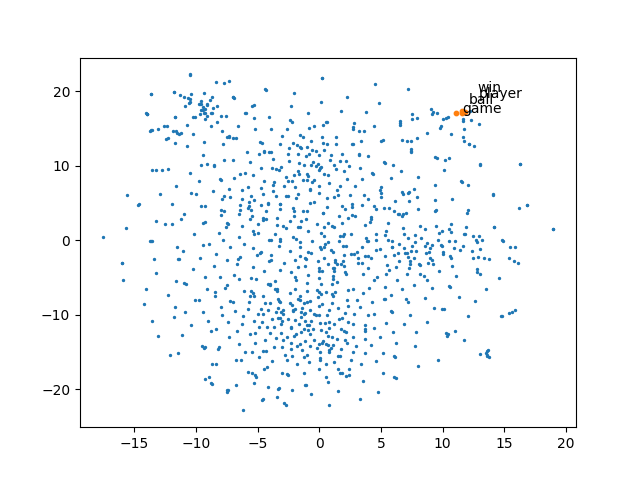

In [105]:
display_tsne_neighborhood(glove, input_word = ['game', 'ball', 'player', 'win'])

<IPython.core.display.Javascript object>


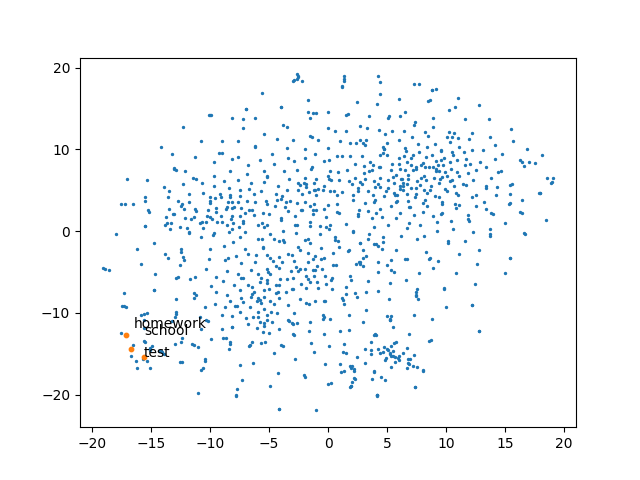

In [106]:
display_tsne_neighborhood(glove, input_word = ['test', 'homework', 'school'])

<IPython.core.display.Javascript object>


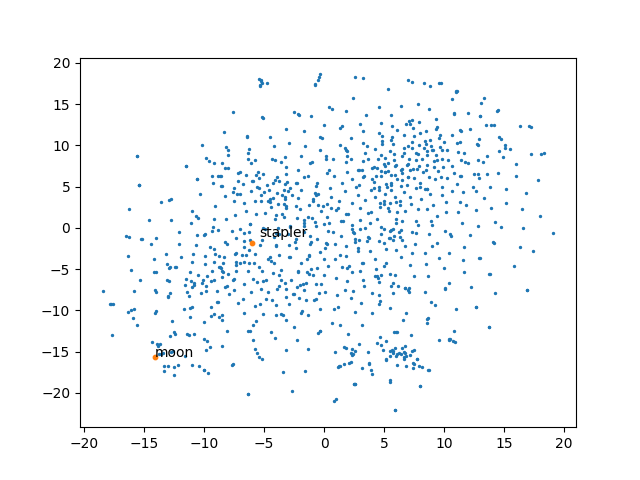

In [102]:
display_tsne_neighborhood(glove, input_word = ['moon','stapler'])

<IPython.core.display.Javascript object>


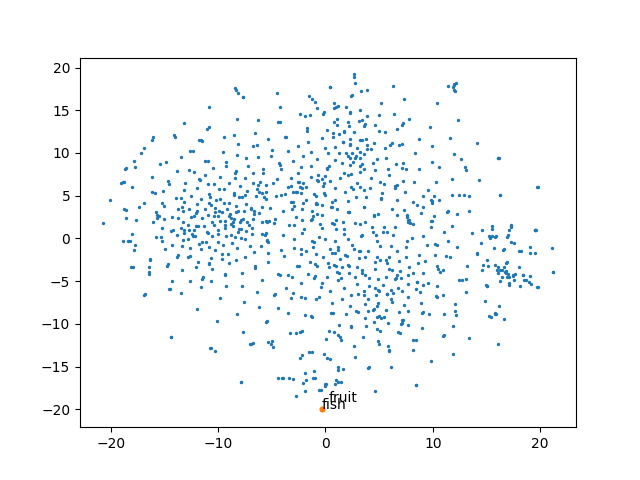

In [133]:
#Find Surprising
display_tsne_neighborhood(glove, input_word = ['fish','fruit'])

<IPython.core.display.Javascript object>


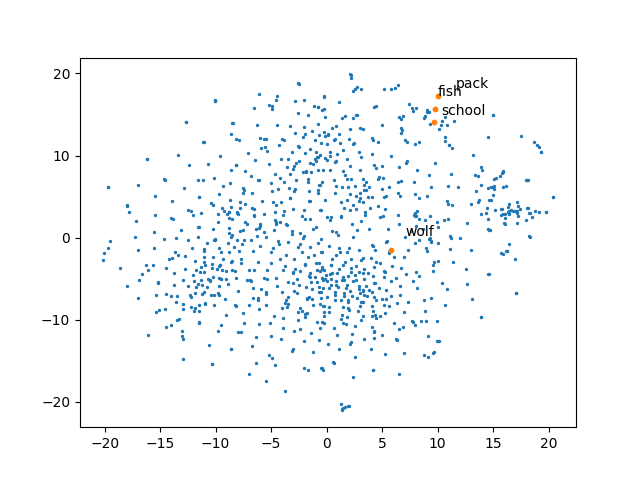

In [136]:
#Find Surprising
display_tsne_neighborhood(glove, input_word = ['fish', 'school','wolf','pack'])

<IPython.core.display.Javascript object>


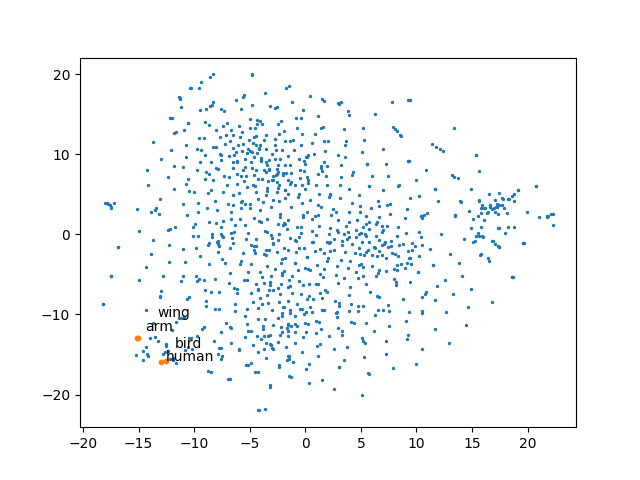

In [137]:
#Find Surprising
display_tsne_neighborhood(glove, input_word = ['human', 'arm','bird','wing'])

### Comments:

The first three plots are all expectedly grouped. "Game", "ball", "player", and "win" are all grouped together, because they are all associated with sports and playing games. Similarly, we see school related words "school","homework", and "test" are closely grouped together. Unrelated words "moon" and "stapler" are appropriately far apart in the t-SNE space.

Surprisingly, we see that "fish" and "fruit" are very close in the t-SNE visualization of the GloVe word embeddings. "Fruit" is actually the number one of most the similar words to fish according to the results in 2a for the PMI and word2vec embeddings.

I also visualized "wolf","pack","fish", and "school" because I was getting weird results for the analogy portion of this question. "Fish" and "school" were unsurprisingly close. However, "pack" and "wolf" were very far apart and "pack" was actually very closely grouped with "fish" and "school". This may lend some insight into why the analogy is not being completed above, "wolf" and "pack" are not being closely associated (maybe because it is actually spelled "wolfpack", but I imagine there would be some contexts as "pack of wolves"?)

I also wanted to visualize "human","arm","bird", and "wing" to try and understand the results to that analogy. Unlike above, we found that all of them were generall grouped together. I am then surprised that we do not get better answers to the completion of the analogy. Looking closely at the groupings we see that "bird" and "human" are most close and "wing" and "arm" were most close. This may suggest that the analogy human : bird :: arm : ? might suggest "wing" as a possible completion to the analogy instead. I will actually test this below...

In [141]:
glove.most_similar(positive=['arm', 'bird'], negative=['human'],topn=1)
#Unfortunately, we still do not see great results for this analogy.

[('shoulder', 0.5614462494850159)]

# Problem 3 - Musician Embeddings 

In [ ]:
playlists = word2vec.LineSentence('playlists.txt')
music_model = word2vec.Word2Vec(playlists, size=64, window=100, min_count=10)

## Part 3a - finding similar artists

In [ ]:
id2name = {}
name2id = {}
for w in range(len(artist)):
    id2name["%s" % w] = artist[w]
    name2id[artist[w]] = "%s" % w

In [ ]:
def similar_artists(model, artist, n=5):
    id = name2id[artist]
    out = model.wv.most_similar(id, topn=n)

    print("artists similar to '%s'\n" % artist)
    for i in range(n) :
        name = id2name[out[i][0]]
        print("\t%s" % name)

In [142]:
similar_artists(music_model, 'The Beatles')

artists similar to 'The Beatles'

	The Electric Light Orchestra
	Steppenwolf
	Creedence Clearwater Revival
	Grand Funk Railroad
	T. Rex


In [143]:
similar_artists(music_model, 'Lady Gaga')

artists similar to 'Lady Gaga'

	Bruno Mars
	Katy Perry
	Ke$ha
	Black Eyed Peas
	Taio Cruz


In [144]:
similar_artists(music_model, 'Nirvana')

artists similar to 'Nirvana'

	Stone Temple Pilots
	The Red Hot Chili Peppers
	Pearl Jam
	Jet
	Foo Fighters


### Comments:

The similar artists for Lady Gaga are not very suprising. They are all contemporary pop artists. Katy Perry and Bruno Mars would be considered musical peers and have been atop the pop charts alongside Lady Gaga over the past several years. It would make sense they are on many popular music playlists together.

For Nirvana, we also see musical peers. It is not suprising we see the Foo Fighters, whose founder and primary vocalists Dave Grohl was the drummer of Nirvana before the death of Kurt Cobain brought an end to the band. Pearl Jam as well is very similar musically, playing harder alternative and grunge rock. Both bands were actually formed in Washington state in the 1990s and became very popular in the Seattle grunge rock scene.

The similar artists for The Beatles are slightly less expected. Electric Light Orchestra, though certainly influenced by The Beatles, were formed in the 1970s and have much more synthesized music (I personally would not have expected them as the most similar artist). We also see Creedence Clearwater Revival, Steppenwolf, and Grand Funk Railroad as a very similar artists. They are all American country and blues rock bands, which seem fairly different to that of the Beatles. However, this may speak to the eclectic nature of the Beatles musical catalog. I am surprised to not see more psychedelic rock bands of the 1960s as The Beatles went through an experimental musical phase in the mid to late 1960s and were influential to the development of psychedelic rock.

## Part 3b - t-SNE visualizations of artists

In [ ]:
# this functions computes and displays the 2-d t-SNE maps for a subset of the embedding vectors
# and displays them together with the points for a set of input words.

def display_tsne_artists(model, artists, nsample=1000, size1=2, size2=10, offset=5):
    #set seed again to ensure the same visualizations
    np.random.seed(seed=0)
    arr = np.empty((0,64), dtype='f')

    # add the vector for each of the closest words to the array
    for a in range(len(artists)):
        id = name2id[artists[a]]
        arr = np.append(arr, np.array([model[id]]), axis=0)

    voc = [w for w in model.wv.vocab]
    ids = np.random.choice(range(len(voc)), size=nsample, replace=False)
    for w in ids:
        wrd_vector = model[voc[w]]
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coord = Y[:, 0]
    y_coord = Y[:, 1]
    # display scatter plot
    size=2
    plt.scatter(x_coord, y_coord, s=size1)
    plt.scatter(x_coord[0:len(artists)], y_coord[0:len(artists)],s=size2)
    
    # label the input words
    for w in range(len(artists)):
        plt.annotate(artists[w], xy=(x_coord[w],y_coord[w]), \
                     xytext=(w*offset,w*offset), textcoords='offset points')
    plt.show()

<IPython.core.display.Javascript object>


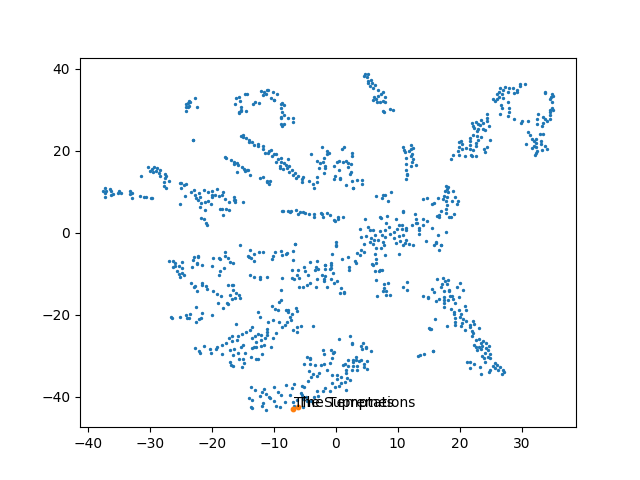

In [155]:
display_tsne_artists(music_model,['The Temptations', 'The Supremes'],nsample=1000, offset=1)

<IPython.core.display.Javascript object>


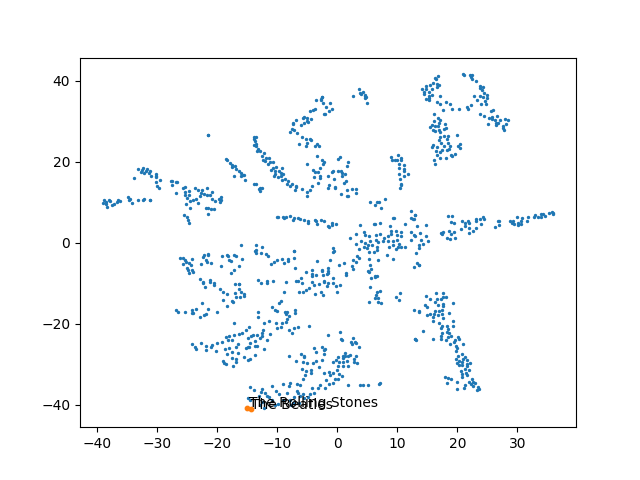

In [156]:
display_tsne_artists(music_model,['The Beatles', 'The Rolling Stones'],nsample=1000, offset=1)

<IPython.core.display.Javascript object>


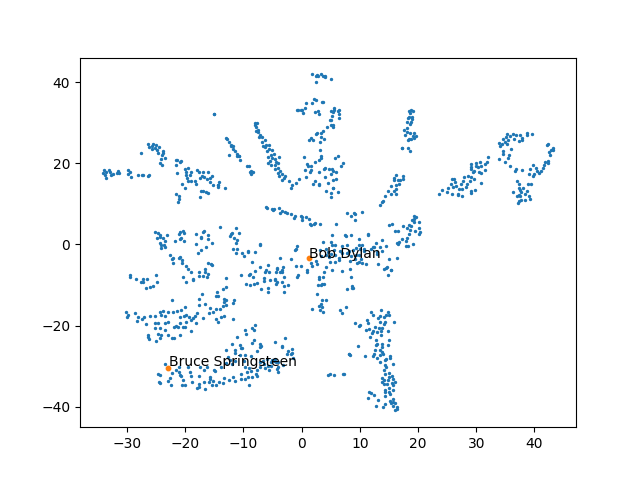

In [157]:
display_tsne_artists(music_model,['Bob Dylan', 'Bruce Springsteen'],nsample=1000, offset=1)

<IPython.core.display.Javascript object>


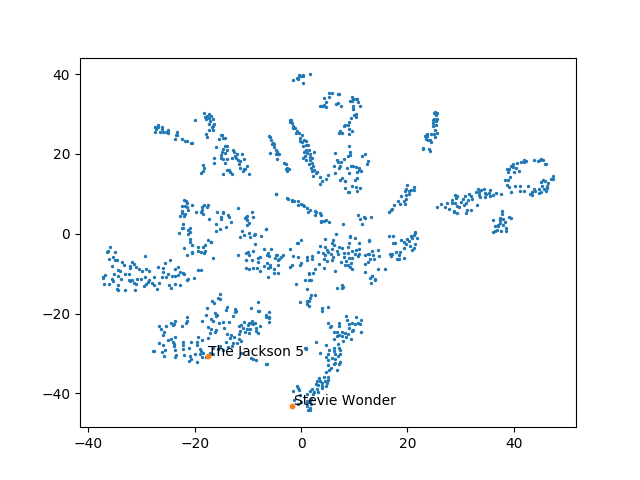

In [158]:
display_tsne_artists(music_model,['The Jackson 5', 'Stevie Wonder'],nsample=1000, offset=1)

### Comments:

In general, the t-SNE artist embedding visualization is more clustered than that of the word embeddings. This makes sense because music playlists and artists tend to be more separated into distinct genres. However, words can be used in an array of different sentence contexts, which is why we see a larger point cloud for the t-SNE visualization of the word embeddings.

The Temptations and The Supremes are closely grouped because both were very popular soul and R&B groups in the 1960s. In fact, The Supremes were formed by Chess and modeled after Motown's The Temptations.

The first pair I explored was The Beatles and The Rolling Stones. Both British groups were very influential in early development of rock & roll, which would make some sense as to why they were so closely grouped (almost stacked on top of each other). However, The Rolling Stones were a much more blues rock based band and were portrayed as the "bad boys" in contrast "good boys" image of The Beatles. I personally would have expected them to be slightly less grouped as they were.

Bob Dylan and Bruce Springsteen were far apart, which again makes some sense but is also surprising in other ways. Bob Dylan came to popularity in the 1960s before Bruce Springsteen in the 1970s and 80s. Bob Dylan was a folk and country rock artist known for his acoustic style and detailed strophic lyrics. Springsteen is a more electric rock and tradional rock & roll artist. However, he has self identified Dylan as an influence for his lyrical and musical style. They both are famous singer-songwriters known for crafting songs with detailed lyrics. Their differences in instrumental style are likely the reason that the two artists are not close in the t-SNE visualization.

Finally, I compared The Jackson 5 and Stevie Wonder. Both artists were iconic 1960s Motown artists (like the Temptations). Stevie Wonder was a soul, R&B, and pop prodigy who reached popularity in the 1960s and had continued success into the 70s. Similarly The Jackson 5 saw much success in the 1960s on the soul, R&B, and pop charts, before Michael Jackon went on to have an enormously successful independent career. Given their similarities, I would have expected the artists to be grouped closer together in the t-SNE visualization space.